In [1]:
import collections
import os
import jax.numpy as jnp
from six.moves import urllib
import daft as daft
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

warnings.simplefilter('ignore')


2022-06-09 15:28:04.723104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
def load_and_preprocess_radon_dataset(state='MN'):  
  """Preprocess Radon dataset as done in "Bayesian Data Analysis" book.

  We filter to Minnesota data (919 examples) and preprocess to obtain the
  following features:
  - `log_uranium_ppm`: Log of soil uranium measurements.
  - `county`: Name of county in which the measurement was taken.
  - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

  The target variable is `log_radon`, the log of the Radon measurement in the
  house.
  """
  ds = tfds.load('radon', split='train')
  radon_data = tfds.as_dataframe(ds)
  print(radon_data.columns)
  radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
  df = radon_data[radon_data.state==state.encode()].copy()
  # For any missing or invalid activity readings, we'll use a value of `0.1`.
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  # Make county names look nice. 
  df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = list(map(str.strip, county_name))

  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['Uppm'].apply(np.log)
  df = df[['idnum', 'log_radon', 'floor', 'county', 'log_uranium_ppm']]

  return df, county_name
radon,county_name = load_and_preprocess_radon_dataset()

radon.head

2022-06-09 15:28:13.210114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 15:28:13.210142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Index(['activity', 'features/Uppm', 'features/adjwt', 'features/basement',
       'features/cntyfips', 'features/county', 'features/dupflag',
       'features/floor', 'features/idnum', 'features/lat', 'features/lon',
       'features/pcterr', 'features/region', 'features/rep', 'features/room',
       'features/startdt', 'features/starttm', 'features/state',
       'features/state2', 'features/stfips', 'features/stopdt',
       'features/stoptm', 'features/stratum', 'features/typebldg',
       'features/wave', 'features/windoor', 'features/zip',
       'features/zipflag'],
      dtype='object')


<bound method NDFrame.head of        idnum  log_radon  floor  county  log_uranium_ppm
8       5161   1.791759      0       6         0.271614
29      5926   2.501436      0      79        -0.147484
32      5793  -0.223144      0      69        -0.474674
39      5829   1.193922      0      69        -0.474674
60      5231   1.064711      0      17        -0.633391
...      ...        ...    ...     ...              ...
12454   5522   1.871802      0      40         0.394734
12486   5730   1.629241      0      67        -0.683437
12500   5433   1.360977      0      25        -0.096521
12539   5429   1.589235      0      25        -0.096521
12554   5734   1.029619      0      67        -0.683437

[919 rows x 5 columns]>

In [3]:
np.unique(radon['county'].to_numpy())
num_counties = len(county_name)
no_obserations = len(radon)

In [4]:
(radon['floor'] ==0).sum()

766

In [5]:
# Create copies of variables as Tensors.
county = tf.convert_to_tensor(radon['county'], dtype=tf.int32)
floor = tf.convert_to_tensor(radon['floor'], dtype=tf.float32)
log_radon = tf.convert_to_tensor(radon['log_radon'], dtype=tf.float32)
log_uranium = tf.convert_to_tensor(radon['log_uranium_ppm'], dtype=tf.float32)


In [6]:
log_radon

<tf.Tensor: shape=(919,), dtype=float32, numpy=
array([ 1.7917595 ,  2.501436  , -0.22314353,  1.1939224 ,  1.0647107 ,
        3.2809112 ,  1.3609766 ,  1.0647107 ,  0.7419373 ,  2.3223877 ,
        1.5260563 ,  2.4336133 ,  0.5877866 ,  1.0296195 , -0.10536055,
       -0.35667497,  3.1696856 ,  1.8870696 ,  2.9704144 ,  1.0647107 ,
       -0.10536055,  1.0986123 , -0.35667497,  2.4248028 ,  1.4350845 ,
        0.8754688 ,  1.1314021 ,  0.7884574 ,  0.47000363,  2.2082744 ,
        1.4350845 ,  1.1939224 ,  2.7013612 ,  1.609438  ,  0.91629076,
        2.091864  ,  3.234749  ,  1.704748  ,  0.3364722 ,  1.7917595 ,
        0.7419373 ,  1.3609766 ,  1.3083328 ,  0.6931472 ,  2.3125355 ,
        0.9555114 ,  0.6931472 ,  0.0953102 ,  0.9555114 ,  0.7419373 ,
        2.7725887 ,  1.1939224 , -0.5108256 ,  0.4054651 ,  2.6741486 ,
        1.4586151 ,  1.4816046 ,  1.8870696 ,  0.3364722 ,  0.64185387,
        2.1162555 ,  1.9315214 ,  1.9459101 ,  1.6292405 ,  0.9932518 ,
        0.530628

In [7]:
log_radon[..., tf.newaxis]

<tf.Tensor: shape=(919, 1), dtype=float32, numpy=
array([[ 1.7917595 ],
       [ 2.501436  ],
       [-0.22314353],
       [ 1.1939224 ],
       [ 1.0647107 ],
       [ 3.2809112 ],
       [ 1.3609766 ],
       [ 1.0647107 ],
       [ 0.7419373 ],
       [ 2.3223877 ],
       [ 1.5260563 ],
       [ 2.4336133 ],
       [ 0.5877866 ],
       [ 1.0296195 ],
       [-0.10536055],
       [-0.35667497],
       [ 3.1696856 ],
       [ 1.8870696 ],
       [ 2.9704144 ],
       [ 1.0647107 ],
       [-0.10536055],
       [ 1.0986123 ],
       [-0.35667497],
       [ 2.4248028 ],
       [ 1.4350845 ],
       [ 0.8754688 ],
       [ 1.1314021 ],
       [ 0.7884574 ],
       [ 0.47000363],
       [ 2.2082744 ],
       [ 1.4350845 ],
       [ 1.1939224 ],
       [ 2.7013612 ],
       [ 1.609438  ],
       [ 0.91629076],
       [ 2.091864  ],
       [ 3.234749  ],
       [ 1.704748  ],
       [ 0.3364722 ],
       [ 1.7917595 ],
       [ 0.7419373 ],
       [ 1.3609766 ],
       [ 1.3083328 ],
    

Text(0.5, 1.0, 'Log radon')

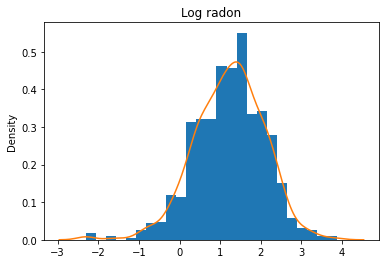

In [8]:
plt.hist(log_radon,bins=25,density=True)
sns.kdeplot(log_radon)
plt.title("Log radon")

## Complete Pooling

Treat all the counties the same and then just fit the model.

Learn one model fitting all the readings.